In [2]:
from dateutil.parser import parse 
import matplotlib as mpl
from matplotlib.pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

Zählungen Preprocessing

In [2]:
Read dataVerkehrsZaehlung = pd.read_csv("https://raw.githubusercontent.com/thereallinusrg/Velo-Zueri-Unfaelle/main/data/2021_verkehrszaehlungen_werte_fussgaenger_velo.csv")

#VeloWege = gpd.read_file(r'data/Velo_wege.gpkg')
#Unfaelle = gpd.read_file(r'data/RoadTrafficAccidentLocations.gpkg')
VerkehrsZaehlung.head()


,FK_ZAEHLER,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,FUSS_IN,FUSS_OUT,OST,NORD
0,U15G3063865,1357,2021-01-01T00:00,NaN,NaN,20.0,0.0,2682973,1246329
1,ECO09113499,3927,2021-01-01T00:00,0.0,3.0,NaN,NaN,2682873,1245891
2,U15G3063867,1358,2021-01-01T00:00,NaN,NaN,4.0,1.0,2683557,1251702
3,U15G3063869,3011,2021-01-01T00:00,NaN,NaN,0.0,5.0,2682978,1248744
4,YSH18065716,3279,2021-01-01T00:00,NaN,NaN,9.0,4.0,2683437,1247199


In [6]:
def resample(df):
  list_stations = df.FK_STANDORT.unique()
  dataframes = []
  for standort in list_stations:
    station = df.loc[df["FK_STANDORT"] == standort]
    station["Date_Hour"] = station["DATUM"].astype(str).str[:13]
    #station = station.set_index(pd.to_datetime(station['DATE_HOUR']))
    grouped = station.groupby("Date_Hour").agg({"FK_STANDORT": min, "VELO_IN": sum, "VELO_OUT": sum, "OST": min, "NORD": min})

    #merged = pd.merge(new, station, on = "DATUM")
    dataframes.append(grouped)
  
  combined = pd.concat(dataframes)

  return combined

Zaehlung_hourly = resample(VerkehrsZaehlung)
Zaehlung_hourly.head(50)

/var/folders/m7/_3h_ct5n68b9x7svmxnmpq980000gn/T/ipykernel_11812/4168483642.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station["Date_Hour"] = station["DATUM"].astype(str).str[:13]
/var/folders/m7/_3h_ct5n68b9x7svmxnmpq980000gn/T/ipykernel_11812/4168483642.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station["Date_Hour"] = station["DATUM"].astype(str).str[:13]
/var/folders/m7/_3h_ct5n68b9x7svmxnmpq980000gn/T/ipykernel_11812/4168483642.py:6: SettingWithCopyWarning: 
A value is trying to be set

,FK_STANDORT,VELO_IN,VELO_OUT,OST,NORD
Date_Hour,,,,,
2021-01-01T00,1357,0.0,0.0,2682973,1246329
2021-01-01T01,1357,0.0,0.0,2682973,1246329
2021-01-01T02,1357,0.0,0.0,2682973,1246329
2021-01-01T03,1357,0.0,0.0,2682973,1246329
2021-01-01T04,1357,0.0,0.0,2682973,1246329
2021-01-01T05,1357,0.0,0.0,2682973,1246329
2021-01-01T06,1357,0.0,0.0,2682973,1246329
2021-01-01T07,1357,0.0,0.0,2682973,1246329
2021-01-01T08,1357,0.0,0.0,2682973,1246329


In [8]:
# Turn it into a GeoDataFrame with point geometries
Zaehlungen = gpd.GeoDataFrame(
    Zaehlung_hourly, geometry=gpd.points_from_xy(Zaehlung_hourly.OST, Zaehlung_hourly.NORD))

<AxesSubplot:>

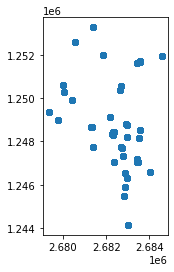

In [9]:
Zaehlungen.plot()

## Normalization

In [ ]:
# Export file, so Voronoi_Tesselation can be done in QGIS. There, all accidents 
# are related to the closests Counting Station.
Zaehlungen.to_file('Zaehlungen_test.gpkg', driver='GPKG', layer='Zaehlungen')  


In [10]:
Accidents_Zaehlstation = gpd.read_file("/Users/HF/Library/Mobile Documents/com~apple~CloudDocs/Data Sciene_Grossi Dateie/Accident_Zaehlstation.gpkg")
Accidents_Zaehlstation_refined = Accidents_Zaehlstation[["AccidentUID", "AccidentSeverityCategory", "AccidentSeverityCategory_de", "geometry", "FK_STANDORT"]]



/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

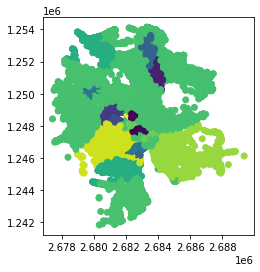

In [11]:
Accidents_Zaehlstation_refined.plot(column='FK_STANDORT', cmap='viridis')

In [12]:
Zaehlungen['Sum_Velos'] = Zaehlungen['VELO_IN'] + Zaehlungen['VELO_OUT']
Zaehlungen.head()

NameError: name 'Zaehlungen' is not defined